In [1]:
pacman::p_load(
  forcats,
  ggplot2,
  data.table,
  tidyr,
  seriation,
  dplyr,
  ggrepel,
  patchwork,
  fractional,
  limma
)

In [2]:
setwd("/data/srlab/slowikow/fibroblast_timecourse")

In [377]:
source("R/002_helper_functions.R")

In [378]:
theme_set(theme_classic(base_size = 18) %+replace% theme(strip.background = element_blank(),
  # axis.line.y = element_line(colour = "black", size = 0.2),
  # axis.line.x = element_line(colour = "black", size = 0.2),
  axis.ticks   = element_line(colour = "black", size = 0.3),
  panel.border = element_rect(size = 0.3, fill = NA),
  axis.line    = element_blank(),
  plot.title   = element_text(size = 18, vjust = 2, hjust = 0.5)
))

In [379]:
sirnas <- c("CUX1", "ELF3", "LIFR", "STAT3", "STAT4")

meta_colors <- list()

meta_colors$sirna <- c(
  "Ctrl"  = "black",
  "CUX1"  = '#1B9E77',
  "STAT3" = '#D95F02',
  "STAT4" = '#7570B3',
  "ELF3"  = '#E7298A',
  "LIFR"  = '#66A61E'
)

meta_colors$Stimulation <- c(
  "None" = "grey50",
  "TNF (1)" = "#FEB24C",
  "TNF (1) + IL17 (1)" = "#E31A1C",
  "TNF (1) + IL17 (10)" = "#800026"
)

meta_colors$dosefactor <- c(
  "0" = meta_colors$Stimulation[["TNF (1)"]],
  "1" = meta_colors$Stimulation[["TNF (1) + IL17 (1)"]],
  "10" = meta_colors$Stimulation[["TNF (1) + IL17 (10)"]]
)

meta_colors$Stimulation <- structure(
  c("grey90", "#FEB24C", "#E31A1C", "#800026"),
  .Names = c("None", "TNF (1)", "TNF (1) + IL17 (1)", "TNF (1) + IL17 (10)")
)

# Read limma results

In [6]:
d1 <- fread("gzip -cd analysis/limma/002_dose_limma_timefactor_dosefactor.tsv.gz")
d2 <- fread("gzip -cd analysis/limma/003_sirna_limma_dosetime_sirna.tsv.gz")

list.files("analysis/limma")

[1] "002_dose_limma_timefactor_dosefactor.tsv.gz"       
[2] "002_microarray-data-1_limma_contrasts.tsv.gz"      
[3] "002_microarray-data-2_limma_contrasts.tsv.gz"      
[4] "002_microarrays_limma_timefactor_stimfactor.tsv.gz"
[5] "003_sirna_limma_dosetime_sirna.tsv.gz"             
[6] "cats.rds"

In [7]:
head(d1)
head(d2)

ID,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,ensembl_id,Coef,signif
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<lgl>
GAPDH,12.2361,12.1392,12.3330,11.9755,249.3115,1.073e-216,2.133e-212,449.8856,ENSG00000111640,Intercept,TRUE
TPT1,12.2502,12.1431,12.3573,12.1497,225.8334,1.524e-209,1.515e-205,439.2062,ENSG00000133112,Intercept,TRUE
UBB,10.3344,10.2414,10.4273,10.4976,219.5213,1.707e-207,1.131e-203,436.0108,ENSG00000170315,Intercept,TRUE
SRP14,9.1075,9.0214,9.1936,9.0615,208.7697,7.266e-204,3.611e-200,430.2092,ENSG00000140319,Intercept,TRUE
COX4I1,9.6292,9.5299,9.7285,9.6275,191.4095,1.355e-197,5.386e-194,419.7734,ENSG00000131143,Intercept,TRUE
PPIB,9.9307,9.8237,10.0376,9.8865,183.3484,1.729e-194,5.729e-191,414.4209,ENSG00000166794,Intercept,TRUE


ID,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,ensembl_id,Coef,FC,FC.R,FC.L
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
HSP90AA1,8.9697,8.8618,9.0776,8.7117,164.0223,4.199e-199,1.213e-194,443.7367,ENSG00000080824,Intercept,1.995e-03,2.149e-03,1.851e-03
ATP6V0E1,9.2405,9.1260,9.3549,9.1111,159.2446,8.619e-197,1.245e-192,438.6129,ENSG00000113732,Intercept,1.653e-03,1.790e-03,1.527e-03
B2M,12.3925,12.2313,12.5537,12.7759,151.7068,5.327e-193,5.129e-189,430.1858,ENSG00000166710,Intercept,1.860e-04,2.080e-04,1.663e-04
FTH1,14.0000,13.8101,14.1899,14.2173,145.4519,1.037e-189,7.489e-186,422.8487,ENSG00000167996,Intercept,6.103e-05,6.962e-05,5.351e-05
VIM,12.3583,12.1832,12.5333,12.3606,139.3005,2.450e-186,1.416e-182,415.3016,ENSG00000026025,Intercept,1.905e-04,2.150e-04,1.687e-04
PCOLCE,9.6990,9.5581,9.8399,9.3786,135.8349,2.263e-184,1.090e-180,410.8946,ENSG00000106333,Intercept,1.203e-03,1.327e-03,1.091e-03


In [8]:
print(names(table(d1$Coef)))
cat("\n")
print(names(table(d2$Coef)))

 [1] "d1"        "d10"       "Intercept" "t10"       "t12"       "t18"      
 [7] "t2"        "t24"       "t4"        "t6"        "t8"       

 [1] "CUX1"      "d0t1"      "d0t16"     "d0t6"      "d1t1"      "d1t16"    
 [7] "d1t6"      "ELF3"      "Intercept" "LIFR"      "STAT3"     "STAT4"    


In [9]:
x1 <- d1 %>%
filter(Coef %in% c("d1")) %>%
arrange(ensembl_id)

x2 <- d1 %>%
filter(Coef %in% c("d10")) %>%
arrange(ensembl_id)

all(x1$ensembl_id == x2$ensembl_id)

ix <- (
  ( (x1$logFC + x2$logFC) / 2 > log2(2) ) &
  ( x1$adj.P.Val < 0.05 | x2$adj.P.Val < 0.05)
)

genes_il17 <- x1$ID[ix]
sprintf("%s TNF+IL17 genes", length(genes_il17))

[1] TRUE

[1] "36 TNF+IL17 genes"

In [10]:
# genes_il17  <- unique(subset(
#   d1, Coef == "d1" & logFC > log2(2) & adj.P.Val < 0.05
# )$ID)
# sprintf("%s TNF+IL17 genes", length(genes_il17))

# genes_il17  <- intersect(genes_il17, unique(subset(
#   d1, Coef == "d10" & logFC > log2(2) & adj.P.Val < 0.05
# )$ID))
# sprintf("%s TNF+IL17 genes", length(genes_il17))

sirnas <- c("CUX1", "LIFR", "STAT3", "STAT4", "ELF3")

genes_sirna <- unique(subset(
  d2, Coef %in% sirnas & logFC < -log2(1.5) & adj.P.Val < 0.05
)$ID)
sprintf("%s sirna genes", length(genes_sirna))

d_genes <- intersect(genes_il17, genes_sirna)
sprintf("%s genes in intersection", length(d_genes))

# Genes we tested with ChIP-QPCR
genes_chip <- c("IL6", "CXCL2", "CXCL1", "CXCL3", "LIF", "CXCL8", "CCL20")
# genes_chip <- c()

d_genes <- union(d_genes, genes_chip)
sprintf("%s total genes, including ChIP-QPCR genes", length(d_genes))

# Sort genes by si-CUX1 p-value
d_genes <- (
  d2 %>%
  filter(Coef == "CUX1" & ID %in% d_genes) %>%
  arrange(-P.Value)
)$ID

print(d_genes)

[1] "394 sirna genes"

[1] "12 genes in intersection"

[1] "16 total genes, including ChIP-QPCR genes"

 [1] "CCL8"    "IL6"     "MMP3"    "STC1"    "CCL20"   "NAMPTP1" "NAMPT"  
 [8] "CXCL8"   "CCL7"    "CXCL3"   "LIF"     "ADORA2A" "CXCL6"   "CXCL1"  
[15] "MFSD2A"  "CXCL2"  


In [11]:
o_mat <- (
  rbind(d1, d2, fill = TRUE) %>% filter(ID %in% d_genes, Coef %in% c("CUX1", "LIFR")) %>%
  mutate(P.Value = -log10(P.Value)) %>%
  reshape2::dcast(formula = ID ~ Coef, value.var = "P.Value") %>%
  tibble::column_to_rownames("ID") %>%
  as.matrix
)
o_mat
# o <- seriate(x = o_mat, method = "BEA_TSP")[[1]]
o <- seriate(x = o_mat, method = "PCA")[[1]]
d_genes <- rev(rownames(o_mat)[o])
d_genes

,CUX1,LIFR
ADORA2A,2.78357017,0.44093167
CCL20,0.59533730,2.40582852
CCL7,1.68193667,7.16184382
CCL8,0.04383157,5.12262865
CXCL1,3.40186635,0.10121999
CXCL2,4.56129947,0.36031434
CXCL3,1.88272870,0.04291974
CXCL6,2.90552887,0.52287875
CXCL8,1.20760831,0.02521207
IL6,0.22329882,1.89619628


[1] "CCL7"    "CCL8"    "STC1"    "MMP3"    "CCL20"   "IL6"     "NAMPTP1"
 [8] "NAMPT"   "MFSD2A"  "LIF"     "CXCL8"   "CXCL6"   "CXCL3"   "ADORA2A"
[15] "CXCL1"   "CXCL2"

In [12]:
#   d1 %>% filter(ID %in% d_genes & Coef %in% c("d10")) %>% arrange(P.Value) %>% select(-signif)

# d2 %>% filter(ID %in% d_genes & Coef %in% sirnas) %>% arrange(P.Value) %>% select(-FC, -FC.R, -FC.L)

In [13]:
coef_to_stim <- c("d1" = "TNF (1) + IL17 (1)", "d10" = "TNF (1) + IL17 (10)")
for (x in c("Intercept", "t10", "t12", "t18", "t2", "t24", "t4", "t6", "t8")) {
  coef_to_stim[x] <- "TNF (1)"
}

d1$Stimulation <- coef_to_stim[d1$Coef]

# Plot limma results

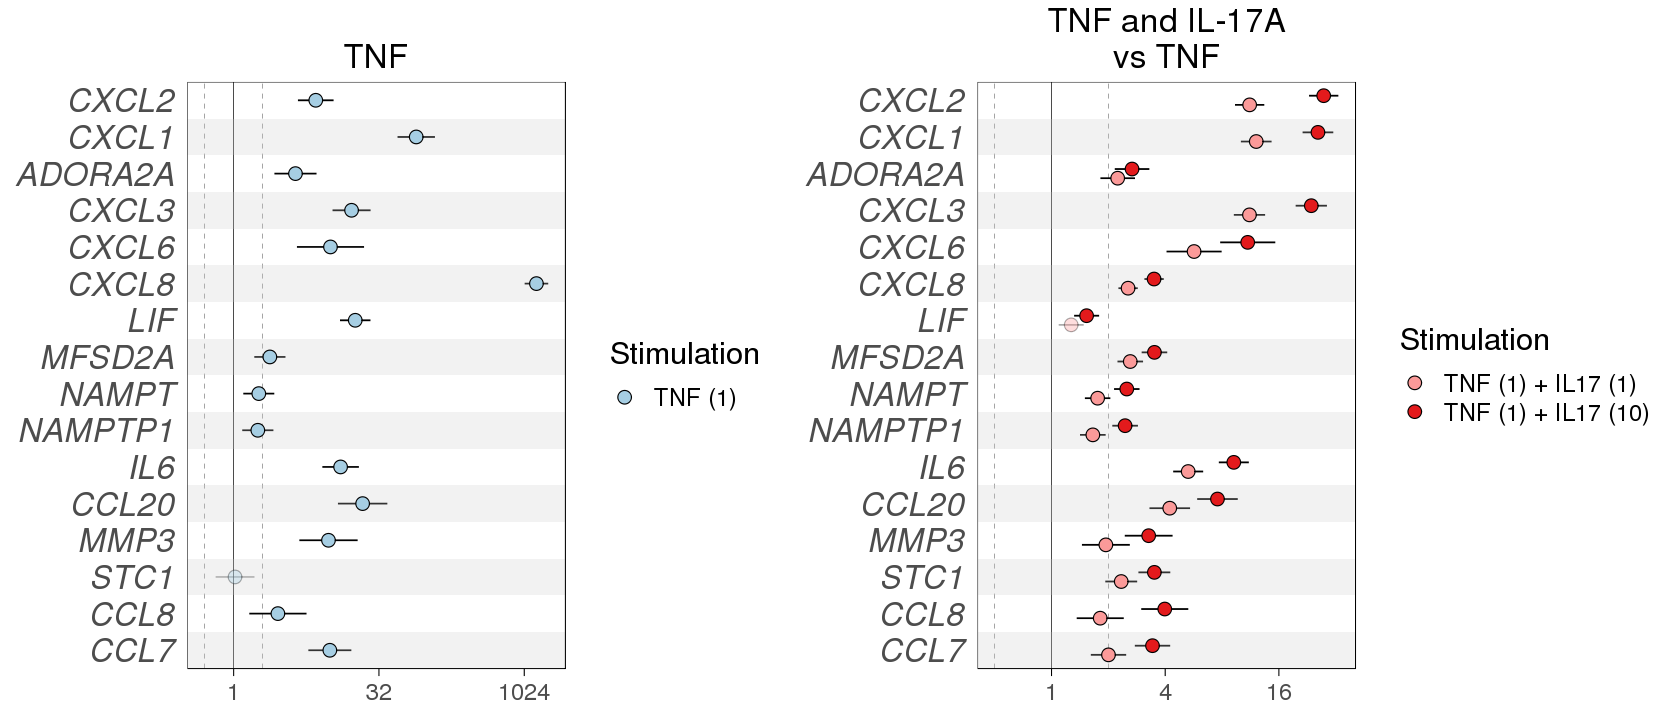

In [139]:
plot_coef <- function(fit1_top, coef = "t6", these_genes = c("RASD1", "CXCL1"), title = "TNF") {
  
#   fill_values <- meta_colors$Stimulation[["TNF (1)"]]
#   if (coef %in% c("d1", "d10")) {
#     fill_values <- meta_colors$Stimulation[["TNF (1)"]]
  
  d <- fit1_top %>%
  filter(ID %in% these_genes) %>%
  mutate(ID = factor(as.character(ID), these_genes)) %>%
  filter(Coef %in% c(coef)) %>%
  mutate(signif = adj.P.Val < 0.05)
  
  ggplot(d) +
  coord_flip() +
  geom_hline(yintercept = 0, size = 0.2) +
  geom_hline(yintercept = log2(c(1/2, 2)), size = 0.1, linetype = 2) +
  geom_errorbar(
    mapping = aes(x = ID, ymin = CI.L, ymax = CI.R, alpha = signif, group = Coef),
    width = 0,
    size = 0.5,
    position = position_dodge(width = 0.5)
  ) +
  annotate(
    geom = "rect",
    ymin = -Inf, ymax = Inf,
    xmin = seq(0.5, length(these_genes) - 0.5, by = 2),
    xmax = seq(0.5, length(these_genes) - 0.5, by = 2) + 1,
    fill = "grey80",
    alpha = 0.25
  ) +
  geom_point(
    mapping = aes(x = ID, y = logFC, alpha = signif, group = Coef, fill = Stimulation),
    position = position_dodge(width = 0.5),
    shape = 21, size = 3.5, stroke = 0.5
  ) +
  scale_fill_manual(values = meta_colors$Stimulation) +
  scale_alpha_manual(
    guide = FALSE,
    name = NULL,
    values = c(
      "TRUE" = 1,
      "FALSE" = 0.33
    )
  ) +
  guides(fill = guide_legend(override.aes = list(size = 3.5))) +
  scale_x_discrete(expand = c(0, 0.5)) +
  scale_y_continuous(
    labels = function(x) fractional(2^x),
    breaks = scales::pretty_breaks(3)
  ) +
  labs(title = title, y = NULL, x = NULL) +
  theme(
    legend.title = element_text(size = 18),
    plot.title = element_text(size = 20, hjust = 0.5),
    legend.position = "right",
    panel.grid.major = element_blank(),
    # panel.grid.major = element_line(size = 0.2, color = "grey80"),
    panel.spacing = unit(1, "lines"),
    axis.text.y = element_text(face = "italic", size = 20),
    axis.ticks.y = element_blank(),
    strip.text = element_text(face = "italic")
  )
}

# these_genes <- c("RASD1")
these_genes <- d_genes
p1 <- plot_coef(d1, coef = "t6", these_genes = these_genes)
p2 <- plot_coef(d1, coef = c("d1", "d10"), title = "TNF and IL-17A\nvs TNF", these_genes = these_genes)

options(repr.plot.width = 14, repr.plot.height = 2 + length(these_genes) * 0.25)

show_plot(p1 + p2)

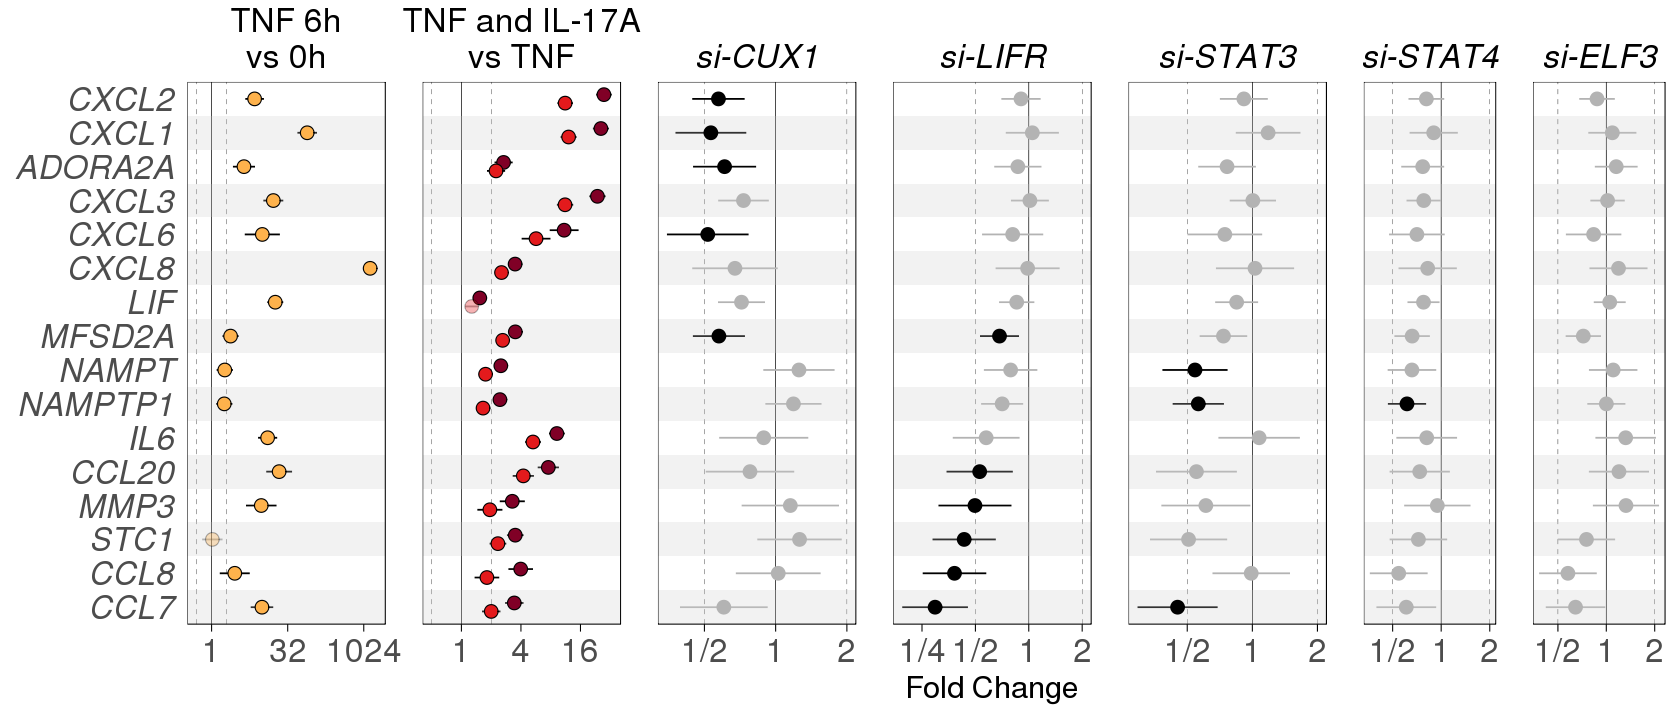

In [15]:
these_genes <- d_genes

p1 <- plot_coef(d1, coef = "t6", title = "TNF 6h\nvs 0h", these_genes = these_genes) +
  theme(
    legend.position = "none",
    axis.text.x = element_text(size = 20)
  )

p2 <- plot_coef(d1, coef = c("d1", "d10"), title = "TNF and IL-17A\nvs TNF", these_genes = these_genes) +
  theme(
    legend.position = "none",
    axis.ticks.y = element_blank(),
    axis.text.y = element_blank(),
    axis.text.x = element_text(size = 20)
  )

plot_sirna_effects4 <- function(d, these_genes, this_sirna) {
  d %>%
  dplyr::filter(Coef %in% this_sirna) %>%
  dplyr::filter(ID %in% c(these_genes)) %>%
  mutate(ID = factor(as.character(ID), these_genes)) %>%
  dplyr::select(Coef, ID, logFC, CI.L, CI.R, adj.P.Val) %>%
  reshape2::melt(id.vars = c("ID", "Coef")) %>%
  reshape2::dcast(formula = ID + Coef ~ variable, value.var = "value") %>%
  mutate(FC = 2 ^ logFC) %>%
  mutate(signif = adj.P.Val < 0.05) %>%
  ggplot() +
  coord_flip() +
  geom_hline(yintercept = 0, size = 0.2) +
  geom_hline(yintercept = log2(c(1/2, 2)), size = 0.1, linetype = 2) +
  geom_errorbar(
    mapping = aes(x = ID, ymin = CI.L, ymax = CI.R, color = signif),
    width = 0,
    size = 0.5
  ) +
  annotate(
    geom = "rect",
    ymin = -Inf, ymax = Inf,
    xmin = seq(0.5, length(these_genes) - 0.5, by = 2),
    xmax = seq(0.5, length(these_genes) - 0.5, by = 2) + 1,
    fill = "grey80",
    alpha = 0.25
  ) +
  geom_point(
    mapping = aes(x = ID, y = logFC, color = signif),
    size = 3.5, stroke = 0.5
  ) +
  scale_alpha_manual(
    guide = FALSE,
    name = NULL,
    values = c("TRUE" = 1, "FALSE" = 0.33)
  ) +
  scale_color_manual(
    guide = FALSE,
    name = NULL,
    values = c("TRUE" = "black", "FALSE" = "grey70")
  ) +
  scale_x_discrete(expand = c(0, 0.5)) +
  scale_y_continuous(
    labels = function(x) fractional(2^x),
    breaks = scales::pretty_breaks(3)
  ) +
  labs(title = this_sirna, y = NULL, x = NULL) +
  theme(
    legend.title = element_text(size = 18),
    plot.title = element_text(size = 20, face = "italic", hjust = 0.5),
    legend.position = "right",
    panel.grid.major = element_blank(),
    # panel.grid.major = element_line(size = 0.2, color = "grey80"),
    panel.spacing = unit(1, "lines"),
#     axis.text.y = element_text(face = "italic"),
    axis.ticks.y = element_blank(),
    axis.text.y = element_blank(),
    axis.text.x = element_text(size = 20),
    strip.text = element_text(face = "italic")
  )
}

p3 <- plot_sirna_effects4(d2, these_genes, "CUX1") + labs(title = "si-CUX1")
p4 <- plot_sirna_effects4(d2, these_genes, "LIFR") + labs(title = "si-LIFR", y = bquote("Fold Change"))
p5 <- plot_sirna_effects4(d2, these_genes, "STAT3") + labs(title = "si-STAT3")
p6 <- plot_sirna_effects4(d2, these_genes, "STAT4") + labs(title = "si-STAT4")
p7 <- plot_sirna_effects4(d2, these_genes, "ELF3") + labs(title = "si-ELF3")

# options(repr.plot.width = 9, repr.plot.height = 1 + length(these_genes) * 0.35)
options(repr.plot.width = 14, repr.plot.height = 2 + length(these_genes) * 0.25)

show_plot(name = "rnaseq-data-2-fig2",
  p1 + p2 + p3 + p4 + p5 + p6 + p7 +
  patchwork::plot_layout(nrow = 1, widths = c(1.5, 1.5, 1.5, 1.5, 1.5, 1, 1)),
)

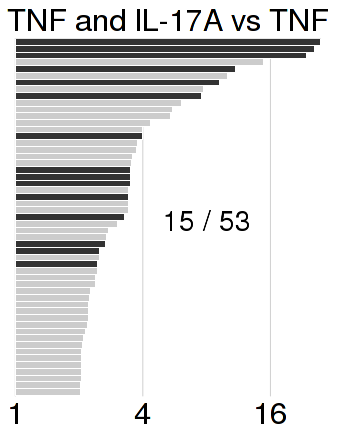

In [16]:

x <- d1 %>%
filter(Coef == "d10") %>%
filter(logFC > 0) %>%
arrange(P.Value) %>%
filter(signif)

options(repr.plot.width = 3, repr.plot.height = 2 + nrow(x) * 0.03)

ggplot(x, aes(x = reorder(ID, logFC), y = logFC, fill = ID %in% d_genes)) +
geom_col(width = 1, color = "white", size = 0.2) +
coord_flip() +
labs(x = NULL, y = NULL, title = "TNF and IL-17A vs TNF") +
theme_void() +
annotate(
  geom = "text",
  y = log2(8),
  x = nrow(x) / 2,
  label = sprintf("%s / %s", sum(x$ID %in% d_genes), nrow(x)),
  size = 6
) +
scale_fill_manual(values = c("TRUE" = "grey20", "FALSE" = "grey80")) +
scale_y_continuous(breaks = scales::pretty_breaks(3), labels = function(x) fractional(2 ^ x)) +
theme(
  plot.title = element_text(size = 18, hjust = 0.5),
  plot.margin = margin(l = 0, r = 1, unit = "lines"),
  panel.grid.major.x = element_line(size = 0.2, color = "grey80"),
  axis.text.x = element_text(size = 18),
  axis.ticks.y = element_blank(),
#   axis.text.y = element_text(size = 4),
  axis.text.y = element_blank(),
  legend.position = "none"
)

CXCL1, CXCL2, CXCL3, CXCL6, CXCL8, and NMES1 (C15orf48) (mean fold-change 1.7, 95% CI: 1.2, 2.2)

# Load gene categories (C1, C2, C3, C4, C5)


In [17]:
cats <- readRDS("analysis/limma/cats.rds")

print(sapply(cats, length))

   C1    C2    C3    C4    C5  None 
   26    25   370    13   202 19243 


In [18]:
d2$category <- 0
d2$category[d2$ensembl_id %in% cats$C1] <- 1
d2$category[d2$ensembl_id %in% cats$C2] <- 2
d2$category[d2$ensembl_id %in% cats$C3] <- 3
d2$category[d2$ensembl_id %in% cats$C4] <- 4
d2$category[d2$ensembl_id %in% cats$C5] <- 5

table(d2$category)


     0      1      2      3      4      5 
339024    312    300   4440    156   2424 

Coef,category,induced,repressed
<chr>,<chr>,<int>,<int>
si-CUX1,C1 (n = 26),0,0
si-CUX1,C2 (n = 25),2,5
si-CUX1,C3 (n = 370),10,7
si-CUX1,C4 (n = 13),0,2
si-CUX1,C5 (n = 202),26,1
si-ELF3,C1 (n = 26),0,0


Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”

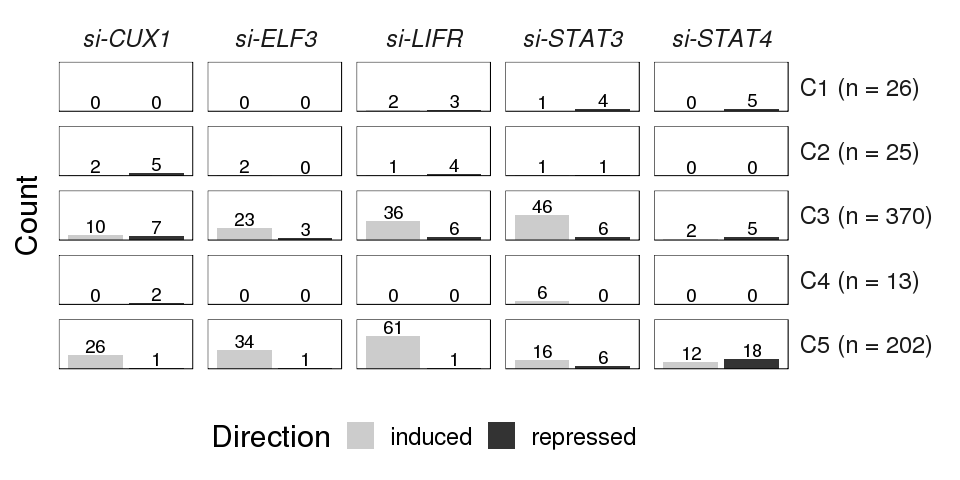

In [19]:
x <- d2 %>%
filter(category != 0) %>%
filter(Coef %in% c("CUX1", "LIFR", "STAT3", "STAT4", "ELF3")) %>%
group_by(Coef, category) %>% 
summarize(
  induced = sum(logFC > log2(1.5) & adj.P.Val < 0.05),
  repressed = sum(logFC < log2(1 / 1.5) & adj.P.Val < 0.05),
)

xx <- local({
  x <- d2 %>%
    filter(category != 0) %>%
    dplyr::select(ensembl_id, category) %>%
    unique() %>% 
    count(category) %>%
    mutate(category_label = sprintf("C%s (n = %s)", category, scales::comma(n)))
  xx <- unlist(split(x$category_label, x$category))
  xx[["0"]] <- "NA"
  return(xx)
})
x$category <- xx[x$category]
x$Coef <- sprintf("si-%s", x$Coef)

x %>% head

options(repr.plot.width = 8, repr.plot.height = 4)

p <- x %>% gather(key = "direction", value = "count", induced, repressed) %>%
ggplot() +
aes(x = direction, y = count, fill = direction) +
geom_col() +
# geom_text(aes(label = signif(count * 100, 2)), vjust = -0.1) +
geom_text(aes(label = count), vjust = -0.15) +
# coord_flip() +
facet_grid(category ~ Coef) + #, scales = "free") +
scale_fill_manual(values = c("grey80", "grey20")) +
guides(fill = guide_legend(title = "Direction")) +
scale_y_continuous(expand = expand_scale(mult = c(0, 0.5))) +
labs(x = NULL, y = "Count") +
theme(
  legend.position = "bottom",
  strip.text.x = element_text(face = "italic"),
  strip.text.y = element_text(angle = 0, hjust = 0),
  axis.text = element_blank(),
  axis.ticks = element_blank()
)

show_plot(p)

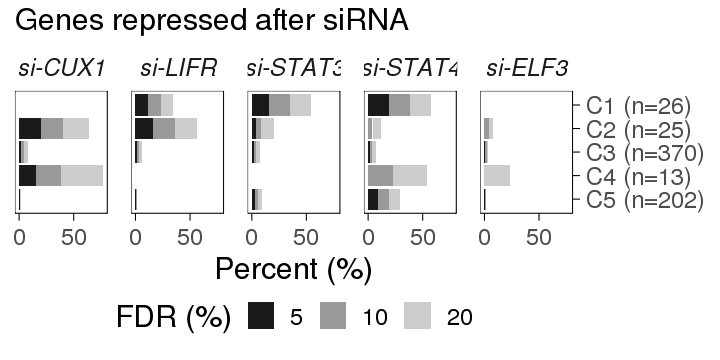

In [74]:
# fdr_threshold <- 0.0.05

x <- do.call(rbind, lapply(c(0.05, 0.1, 0.2), function(fdr_threshold) {
  x <- d2 %>%
  filter(category != 0) %>%
  filter(Coef %in% c("CUX1", "LIFR", "STAT3", "STAT4", "ELF3")) %>%
  group_by(Coef, category) %>% 
  summarize(
    induced = sum(logFC > log2(1.5) & adj.P.Val < fdr_threshold),
    repressed = sum(logFC < log2(1 / 1.5) & adj.P.Val < fdr_threshold),
    total = length(logFC)
  ) %>%
  mutate(fdr = round(100 * fdr_threshold))
}))

xx <- local({
  x <- d2 %>%
    filter(category != 0) %>%
    dplyr::select(ensembl_id, category) %>%
    unique() %>% 
    count(category) %>%
    mutate(
      category_label = sprintf("C%s (n=%s)", category, scales::comma(n))
    )
  xx <- unlist(split(x$category_label, x$category))
  xx[["0"]] <- "NA"
  return(xx)
})
x$category <- xx[x$category]
x$Coef <- sprintf("si-%s", x$Coef)
x$Coef <- factor(x$Coef, levels = c("si-CUX1", "si-LIFR", "si-STAT3", "si-STAT4", "si-ELF3"))

options(repr.plot.width = 6, repr.plot.height = 3)

x <- x %>% mutate(
  pct_induced = 100 * induced / total,
  pct_repressed = 100 * repressed / total
)

p <- ggplot(x) +
aes(x = fct_rev(category), y = pct_repressed, fill = factor(fdr, c(20, 10, 5))) +
facet_grid(~ Coef) +
geom_col() +
coord_flip() +
scale_fill_manual(
  name = "FDR (%)", values = c("grey80", "grey60", "grey10"), guide = guide_legend(reverse = TRUE)
) +
# geom_text(aes(label = sprintf("%s", signif(pct_repressed, 2))), hjust = -0.15) +
scale_x_discrete(position = "top") +
# scale_y_continuous(breaks = scales::pretty_breaks(2), limits = c(0, 100), expand = expand_scale(mult = c(0, 0))) +
scale_y_continuous(breaks = scales::pretty_breaks(2)) +
# scale_y_continuous(breaks = scales::pretty_breaks(2), expand = expand_scale(mult = c(0, 0.7))) +
labs(x = NULL, y = "Percent (%)", title = "Genes repressed after siRNA") +
theme(legend.box.spacing = unit(0, "lines"),
  panel.spacing = unit(1, "lines"),
  plot.title = element_text(hjust = 0),
  legend.position = "bottom",
  strip.text.x = element_text(face = "italic"),
  strip.text.y = element_text(angle = 0, hjust = 0),
#   axis.text.x = element_blank(),
#   axis.ticks = element_blank()
)

show_plot(p)

# Get target genes for CUX1, ELF3, LIFR, STAT3, STAT4


In [21]:
targets <- lapply(c("CUX1", "LIFR", "ELF3", "STAT3", "STAT4"), function(this_coef) {
  (
    d2 %>%
    filter(Coef == this_coef) %>%
    filter(category != 0) %>%
    filter(logFC < log2(1 / 1.5) & adj.P.Val < 0.05) %>%
    dplyr::select(ensembl_id)
  )$ensembl_id
})

In [22]:
sapply(targets, length)

[1] 15 14  4 17 28

In [23]:
d1$category <- 0
d1$category[d1$ensembl_id %in% cats$C1] <- 1
d1$category[d1$ensembl_id %in% cats$C2] <- 2
d1$category[d1$ensembl_id %in% cats$C3] <- 3
d1$category[d1$ensembl_id %in% cats$C4] <- 4
d1$category[d1$ensembl_id %in% cats$C5] <- 5

table(d1$category)


     0      1      2      3      4      5 
211673    286    275   4070    143   2222 

In [24]:
d1 %>% filter(category != 0 & Coef == "d10") %>% count(category)

category,n
<dbl>,<int>
1,26
2,25
3,370
4,13
5,202


# Load RNA-seq expression data

In [25]:
load("data/shiny_rnaseq.rda")
meta <- meta[,!duplicated(colnames(meta))]

sirna <- new.env()
load("data/shiny_rnaseq-sirna.rda", envir = sirna)

Check to see if *IL6* is present in the expression matrices:

In [26]:
names(gene_symbols[which(gene_symbols == "IL6")]) %in% rownames(log2tpm)
names(gene_symbols[which(gene_symbols == "IL6")]) %in% rownames(sirna$log2tpm)

[1] TRUE

[1] TRUE

Reformat the metadata for the dose-response gene expression data:

In [27]:
meta$donor       <- meta$Cell_Line
meta$time        <- meta$Time
meta$timefactor  <- meta$TimeFactor
meta$dose        <- meta$Dose
meta$dosefactor  <- meta$DoseFactor
meta$disease     <- meta$Disease
meta$stimulation <- meta$Stimulation

stopifnot(all(meta$Sample == colnames(log2tpm)))
rownames(meta)  <- colnames(log2tpm)
head(meta)

,Plate,Well,ID,Cell_Line,Stimulation,Time,Concentration,RNA_Prep,Disease,Conc_High,⋯,Age,RF,common_percent,donor,time,timefactor,dose,dosefactor,disease,stimulation
,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<chr>,<lgl>,⋯,<chr>,<dbl>,<dbl>,<chr>,<int>,<fct>,<dbl>,<fct>,<chr>,<chr>
1,1,H11,2-A-2,RA1,TNF (1),2,20.0,1,RA,FALSE,⋯,M,55,0.9961115,RA1,2,2,0,0,RA,TNF (1)
10,1,A04,3-B-2,RA2,TNF (1) + IL17 (1),2,25.8,1,RA,FALSE,⋯,F,NA,0.9914784,RA2,2,2,1,1,RA,TNF (1) + IL17 (1)
100,1,D10,7-A-10,RA4,TNF (1),10,42.1,5,RA,TRUE,⋯,M,NA,0.9956979,RA4,10,10,0,0,RA,TNF (1)
101,1,B02,10-A-10,OA3,TNF (1),10,21.5,5,OA,FALSE,⋯,F,58,0.9966079,OA3,10,10,0,0,OA,TNF (1)
103,1,F04,14-A-10,OA1,TNF (1),10,21.9,5,OA,FALSE,⋯,M,NA,0.9929677,OA1,10,10,0,0,OA,TNF (1)
104,1,C08,15-A-10,OA2,TNF (1),10,26.6,5,OA,FALSE,⋯,M,NA,0.9965252,OA2,10,10,0,0,OA,TNF (1)


In [28]:
log2tpm_batch <- removeBatchEffect(x = log2tpm, batch = meta$donor, batch2 = meta$Plate)

log2tpm_batch[1:5,1:5]

,1,10,100,101,103
ENSG00000000003,5.40729397,5.6630646,4.508251,4.8161029,5.1086200
ENSG00000000419,6.14855689,6.4599919,5.999979,6.2926700,6.4160149
ENSG00000000457,1.84526382,2.3929256,2.390196,2.1753753,2.0410639
ENSG00000000460,2.17356267,2.4129056,3.491149,3.3863130,3.3531833
ENSG00000000938,0.04241437,0.8952589,1.162594,0.2857549,0.6209521


# Cluster genes, apply GAP statistic

In [98]:
my_ens <- (
  d1 %>% filter(category != 0 & Coef == "d10")
)$ensembl_id

In [99]:
library(clusterGenomics)

In [100]:
my_x <- scale_rows(log2tpm_batch[my_ens,])

In [32]:
my_gap <- gap(X = my_x, Kmax = 20, dist.method = "cor")

In [33]:
my_gap$hatK

[1] 2

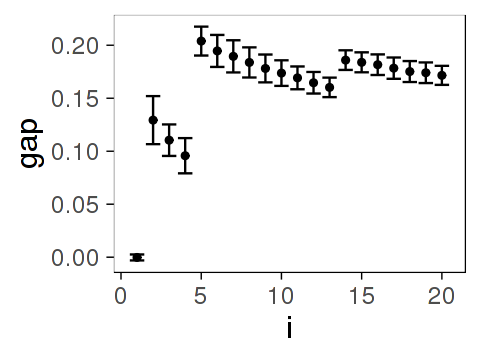

In [34]:
options(repr.plot.width = 4, repr.plot.height = 3)

d_gap <- data.frame(i = seq(length(my_gap$gap)), gap = my_gap$gap, se = my_gap$sk, disp = my_gap$W)

ggplot(d_gap) +
geom_point(aes(i, gap)) +
geom_errorbar(aes(i, ymin = gap - se, ymax = gap + se))

In [78]:
lapply(my_gap, class)

$hatK
[1] "integer"

$lab.hatK
[1] "integer"

$gap
[1] "numeric"

$sk
[1] "numeric"

$W
[1] "numeric"

In [35]:
table(my_gap$lab.hatK)


  1   2 
442 194 

In [80]:
length(my_ens) == 442 + 194

[1] TRUE

In [81]:
getwd()

[1] "/data/srlab/slowikow/fibroblast_timecourse"

In [82]:
my_part_file <- "data/my_part.rds"

if (!file.exists(my_part_file)) {
  my_part <- part(
    X = my_x,
    Kmax = 20,
    minSize = 5,
    Kmax.rec = 5, # max num clusters to consider in each recursive run
    cl.method = "hclust",
    linkage = "average",
    dist.method = "cor"
  )
  saveRDS(my_part, my_part_file)
} else {
  my_part <- readRDS(my_part_file)
}


In [83]:
lapply(my_part, class)

$hatK
[1] "integer"

$lab.hatK
[1] "numeric"

$outliers
[1] "integer"

In [88]:
length(my_part$outliers)

[1] 66

In [86]:
table(my_part$lab.hatK)


  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15 
 66  31  50 150  40  87  43   6  59  28  13   9  28  13   8   5 

In [445]:
length(my_part$lab.hatK)

[1] 636

In [93]:
my_part$lab.hatK[1:5]

[1] 1 1 1 1 2

In [434]:
print(sort(gene_symbols[my_ens[my_part$outliers]]))

ENSG00000255639 ENSG00000268293 ENSG00000268083 ENSG00000228335 ENSG00000266953 
   "AC005833.3"    "AC008751.1"    "AC008982.1"    "AC073063.1"    "AC092073.1" 
ENSG00000243977 ENSG00000204172 ENSG00000258691 ENSG00000216548 ENSG00000276032 
   "AC125604.1"         "AGAP9"    "AL355102.2"    "AL357084.1"    "AL627230.4" 
ENSG00000133805 ENSG00000145020 ENSG00000153094 ENSG00000123095 ENSG00000110934 
        "AMPD3"           "AMT"       "BCL2L11"       "BHLHE41"          "BIN2" 
ENSG00000169085 ENSG00000251303 ENSG00000158966 ENSG00000130176 ENSG00000035664 
      "C8orf46"       "CAB39P1"        "CACHD1"          "CNN1"         "DAPK2" 
ENSG00000105339 ENSG00000105877 ENSG00000116675 ENSG00000164330 ENSG00000131037 
       "DENND3"        "DNAH11"        "DNAJC6"          "EBF1"        "EPS8L1" 
ENSG00000226887 ENSG00000251669 ENSG00000100350 ENSG00000277117 ENSG00000232368 
   "ERVMER34-1"       "FAM86EP"       "FOXRED2"    "FP565260.3"         "FTLP2" 
ENSG00000187210 ENSG00000139

In [436]:
length(my_part$outliers)

[1] 66

In [116]:
my_ens_cat <- c()
for (this_cat in c("C1", "C2", "C3", "C4", "C5")) {
  for (this_ens in cats[[this_cat]]) {
    my_ens_cat[this_ens] <- this_cat
  }
}
my_ens_cat <- my_ens_cat[my_ens]

In [119]:
my_fisher <- fisher.test(x = my_part$lab.hatK, y = my_ens_cat, simulate.p.value = TRUE)

In [120]:
my_fisher


	Fisher's Exact Test for Count Data with simulated p-value (based on
	2000 replicates)

data:  my_part$lab.hatK and my_ens_cat
p-value = 0.0004998
alternative hypothesis: two.sided


## Prepare data for modeling

### Share the first time point

Time point 0 has no stimulation, so it can serve as the reference point for all
other stimulations

In [107]:
# Copy the 0 time point for doses 1 and 10
t0 <- subset(meta, Time == 0)
n0 <- nrow(t0)
t0 <- rbind(t0, t0)
t0$Dose <- rep(c(1, 10), each = n0)
t0$DoseFactor <- rep(c(1, 10), each = n0)
t0$dosefactor <- rep(c(1, 10), each = n0)
t0$DoseExposure <- rep(TRUE, n0 * 2)
meta_zero <- rbind(t0, meta)

We share the 7 RNA-seq samples from the 0h time point with Dose 1 and Dose 10:

In [108]:
table(meta$Dose, meta$Time)

    
     0 2 4 6 8 10 12 18 24
  0  7 7 7 7 7  7  7  7  7
  1  0 7 7 7 7  7  7  7  7
  10 0 7 7 7 7  7  7  7  7

In [109]:
table(meta_zero$Dose, meta_zero$Time)

    
     0 2 4 6 8 10 12 18 24
  0  7 7 7 7 7  7  7  7  7
  1  7 7 7 7 7  7  7  7  7
  10 7 7 7 7 7  7  7  7  7

In [122]:
log2tpm_batch <- removeBatchEffect(x = log2tpm, batch = meta$donor, batch2 = meta$Plate)
log2tpm_zero <- log2tpm_batch[,as.character(meta_zero$Sample)]

Writing file notebooks/figures/gene-clusters.png
Writing file notebooks/figures/gene-clusters.pdf


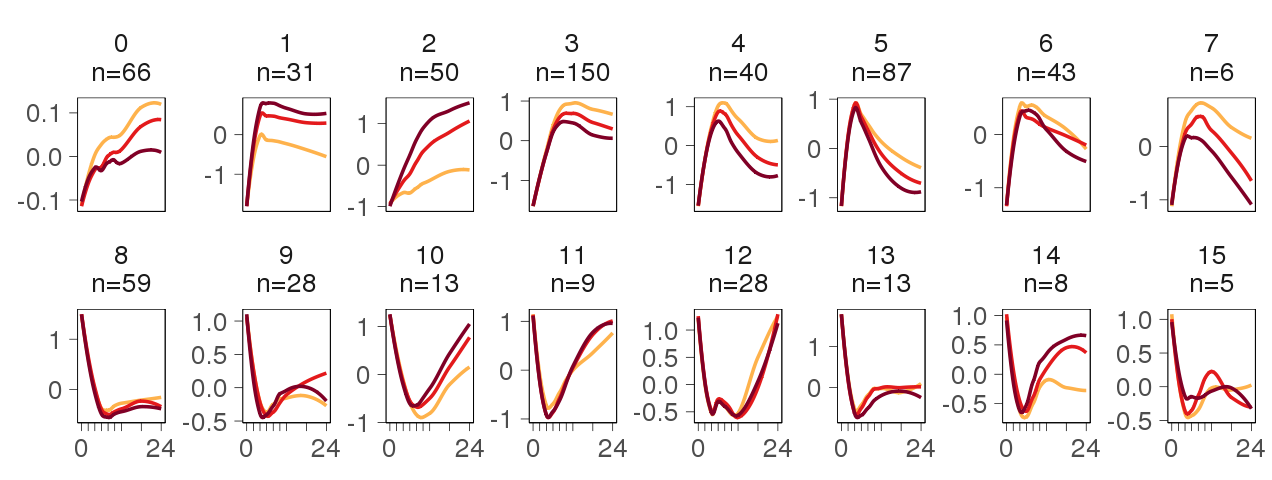

In [380]:
my_part_clusters <- names(table(my_part$lab.hatK))

d <- rbindlist(lapply(my_part_clusters, function(i) {
  ix <- my_ens[my_part$lab.hatK == i]
  # Data for each sample in the expression data.
  d <- meta_zero
  d$cluster <- i
  # Mean of raw values.
  d$log2tpm_mean <- colMeans(scale_rows(
    log2tpm_zero[ix,,drop=FALSE],
    scale = TRUE, center = TRUE
  ))
  return(d)
}))

d_text <- rbindlist(lapply(my_part_clusters, function(i) {
  # Cut the gene dendrogram into clusters.
  ix <- my_ens[my_part$lab.hatK == i]
  data.frame(cluster = i, n_genes = length(ix))
}))
xx <- sprintf("%s\nn=%s", d_text$cluster, d_text$n_genes)
names(xx) <- d_text$cluster
d$cluster_text <- factor(xx[as.character(d$cluster)], unname(xx))

# head(d)

time_breaks <- as.integer(names(table(d$time)))
# time_labels <- rep('', length(time_breaks))
time_labels <- c(
  time_breaks[1],
  rep('', length(time_breaks) - 2),
  time_breaks[length(time_breaks)]
)
names(time_labels) <- time_breaks

n_clusters <- length(unique(d$cluster))

ncol <- min(8, n_clusters)
nrow <- ceiling(n_clusters / ncol)
width <- 1 + 1.2 * ncol
height <- 1 + 1.5 * nrow
options(repr.plot.width = width, repr.plot.height = height)

xx <- meta_colors$Stimulation[2:4]
names(xx) <- c('0', '1', '10')
meta_colors$Dose <- xx

p_cluster <- ggplot() +
  geom_smooth(
    data = d,
    mapping = aes(x = time, y = log2tpm_mean, color = factor(Dose)),
    se = FALSE,
    method = "loess"
  ) +
  facet_wrap(~ cluster_text, ncol = ncol, scales = "free_y") +
  scale_color_manual(values = meta_colors$dosefactor) +
  scale_y_continuous(
    breaks = scales::pretty_breaks(n = 3)
    # breaks = c(2, 8, 14)
  ) +
# scale_x_continuous(breaks = c(1), labels = c(1)) +
  scale_x_continuous(
    breaks = time_breaks,
    labels = time_labels
  ) +
  theme_clean(base_size = 20) +
  theme(
    #axis.ticks.x = element_blank(),
    panel.background = element_rect(color = "black", size = 0.3),
    legend.position = "none", title = element_text(size = 14),
    #strip.background = element_rect(size = NA, fill = NA)
    strip.background = element_blank()
  ) +
  labs(x = NULL, y = NULL)

show_plot(p_cluster, "gene-clusters")

In [244]:
MSIGDB_C2_ENSEMBL %>% length

0.05 / (MSIGDB_C2_ENSEMBL %>% length)

[1] 4172

[1] 1.198466e-05

In [255]:
stringr::str_split_fixed(names(MSIGDB_C2_ENSEMBL), "_", 2)[,1] %>% table %>% sort %>% tail

.
    WANG      LEE     KEGG      PID BIOCARTA REACTOME 
      36       42      179      196      217      641 

In [232]:
gene_symbols[my_ens[which(my_part$lab.hatK == 14)]] %>% print

ENSG00000127954 ENSG00000141401 ENSG00000109452 ENSG00000186918 ENSG00000148541 
       "STEAP4"         "IMPA2"        "INPP4B"        "ZNF395"        "FAM13C" 
ENSG00000046653 ENSG00000120832 ENSG00000100154 
        "GPM6B"        "MTERF2"         "TTC28" 


Writing file notebooks/figures/gene-categories-and-clusters.png
Writing file notebooks/figures/gene-categories-and-clusters.pdf


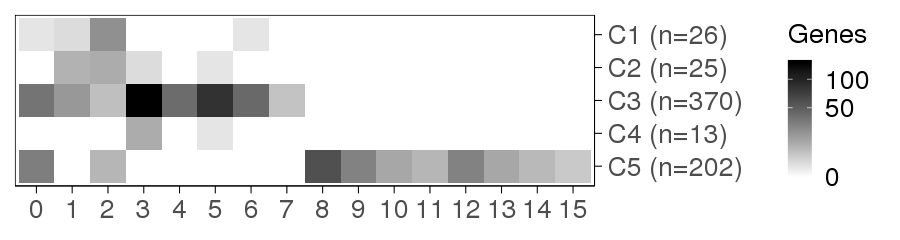

In [400]:
options(repr.plot.width = 7.5, repr.plot.height = 2)

x <- as.matrix(table(my_ens_cat, my_part$lab.hatK))

p_cat <- reshape2::melt(x) %>%
mutate(my_ens_cat = factor(my_ens_cat, rev(c("C1", "C2", "C3", "C4", "C5")))) %>%
ggplot() +
aes(x = factor(Var2), y = my_ens_cat, fill = value) +
scale_y_discrete(position = "r", labels = {
  cat_to_label <- sprintf("%s (n=%s)", names(rowSums(x)), rowSums(x))
  names(cat_to_label) <- names(rowSums(x))
  cat_to_label
})+
geom_tile() +
scico::scale_fill_scico(
  name = "Genes", palette = "grayC", trans = "sqrt",
  guide = guide_colorbar(barheight = 5, barwidth = 1)
) +
# scale_y_discrete(expand = expansion(0, add = 0.535)) +
# scale_x_discrete(expand = expansion(0, add = 0.535)) +
labs(x = NULL, y = NULL) +
# theme_void() +
theme(
  panel.background = element_rect(fill = NA, color = "black", size = 0.3),
  axis.text = element_text(size = 16),
  legend.text = element_text(size = 16),
  legend.title = element_text(size = 16)
)

show_plot(p_cat, "gene-categories-and-clusters")

[1] 63

[1] 78

Writing file notebooks/figures/gene-sirna-and-clusters.png
Writing file notebooks/figures/gene-sirna-and-clusters.pdf


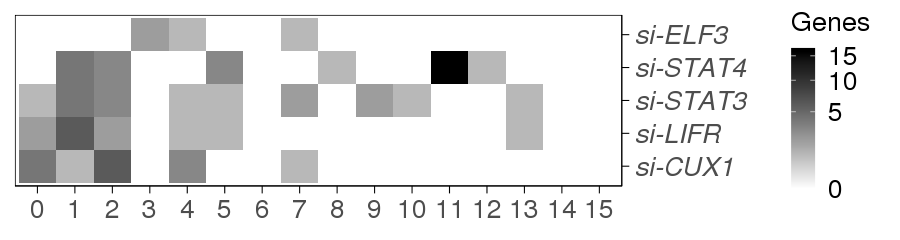

In [468]:
fdr_threshold <- 0.05

# sirna_repressed <- (
  x <- d2 %>%
  filter(category != 0) %>%
  filter(Coef %in% c("CUX1", "LIFR", "STAT3", "STAT4", "ELF3")) %>%
  # group_by(Coef, category) %>% 
  # summarize(
  #   induced = sum(logFC > log2(1.5) & adj.P.Val < fdr_threshold),
  #   repressed = sum(logFC < log2(1 / 1.5) & adj.P.Val < fdr_threshold),
  #   total = length(logFC)
  # ) %>%
  filter(logFC < log2(1 / 1.5) & adj.P.Val < fdr_threshold) %>%
  mutate(fdr = round(100 * fdr_threshold))
# )$ensembl_id

x <- x %>% select(ensembl_id, Coef) %>% unique

length(unique(x$ensembl_id))
nrow(x)

int <- matrix(0, ncol = length(unique(my_part$lab.hatK)), length(unique(x$Coef)))
rownames(int) <- c("CUX1", "LIFR", "STAT3", "STAT4", "ELF3")
colnames(int) <- 0:15

for (i in 0:15) {
  for (j in c("CUX1", "LIFR", "STAT3", "STAT4", "ELF3")) {
    n <- length(intersect(
      my_ens[my_part$lab.hatK == i],
      (x %>% filter(Coef == j))$ensembl_id
    ))
    int[j,i] <- n
  }
}

x <- reshape2::melt(int)

options(repr.plot.width = 7.5, repr.plot.height = 2)

p_sirna <- ggplot(x) +
aes(x = factor(Var2), y = factor(Var1), fill = value) +
scale_y_discrete(position = "r", labels = function(x) sprintf("si-%s", x))+
geom_tile() +
scico::scale_fill_scico(
  name = "Genes", palette = "grayC", trans = "sqrt",
  breaks = scales::pretty_breaks(3),
  guide = guide_colorbar(barheight = 6, barwidth = 1)
) +
labs(x = NULL, y = NULL) +
# theme_void() +
theme(
  panel.background = element_rect(fill = NA, color = "black", size = 0.3),
  axis.text = element_text(size = 16),
  legend.text = element_text(size = 16),
  legend.title = element_text(size = 16),
  axis.text.y = element_text(face = "italic")
)

show_plot(p_sirna, "gene-sirna-and-clusters")

# Gene set enrichment

In [187]:
load("data/gene_sets.rda")

In [482]:
ix <- MSIGDB_C7_ENSEMBL %>% names %>% str_detect("LIF")
names(MSIGDB_C7_ENSEMBL)[ix]

character(0)

In [310]:
fisher_hmark <- do.call(rbind, lapply(my_part_clusters, function(i) {
# i <- 1
  fisher_hmark <- do_fisher(
    ids = my_ens[which(my_part$lab.hatK == i)],
    universe = rownames(log2tpm_batch),
#     universe = my_ens,
#     gene_sets = MSIGDB_C2_ENSEMBL
    gene_sets = MSIGDB_H_ENSEMBL
  )
  fisher_hmark$cluster <- i
  rownames(fisher_hmark) <- seq(nrow(fisher_hmark))
  fisher_hmark
}))

In [437]:
length(rownames(log2tpm_batch))

[1] 19879

In [314]:
# saveRDS(fisher_hmark, "data/fisher_msigdb_c2_ensembl.rds")
fisher_hmark <- readRDS("data/fisher_msigdb_c2_ensembl.rds")

In [336]:
library(stringr)

## Reactome

[1] "Reactome pathways (45/641)"


x,n,X,N,enrichment,orlow,orhigh,or,pval,Name,qval,cluster
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>
1,66,9,19879,33.46633,1.715677,Inf,38.01922,0.02949287,Role of Dcc in Regulating Apoptosis,1,0
1,66,12,19879,25.09975,1.285663,Inf,27.67173,0.03913214,Acyl Chain Remodelling of Pi,1,0
1,66,12,19879,25.09975,1.285663,Inf,27.67173,0.03913214,Purine Salvage,1,0
0,66,12,19879,1.00000,1.000000,1,1.00000,1.00000000,Extrinsic Pathway for Apoptosis,1,0
0,66,10,19879,1.00000,1.000000,1,1.00000,1.00000000,Gap Junction Degradation,1,0
0,66,64,19879,1.00000,1.000000,1,1.00000,1.00000000,Antigen Processing Cross Presentation,1,0


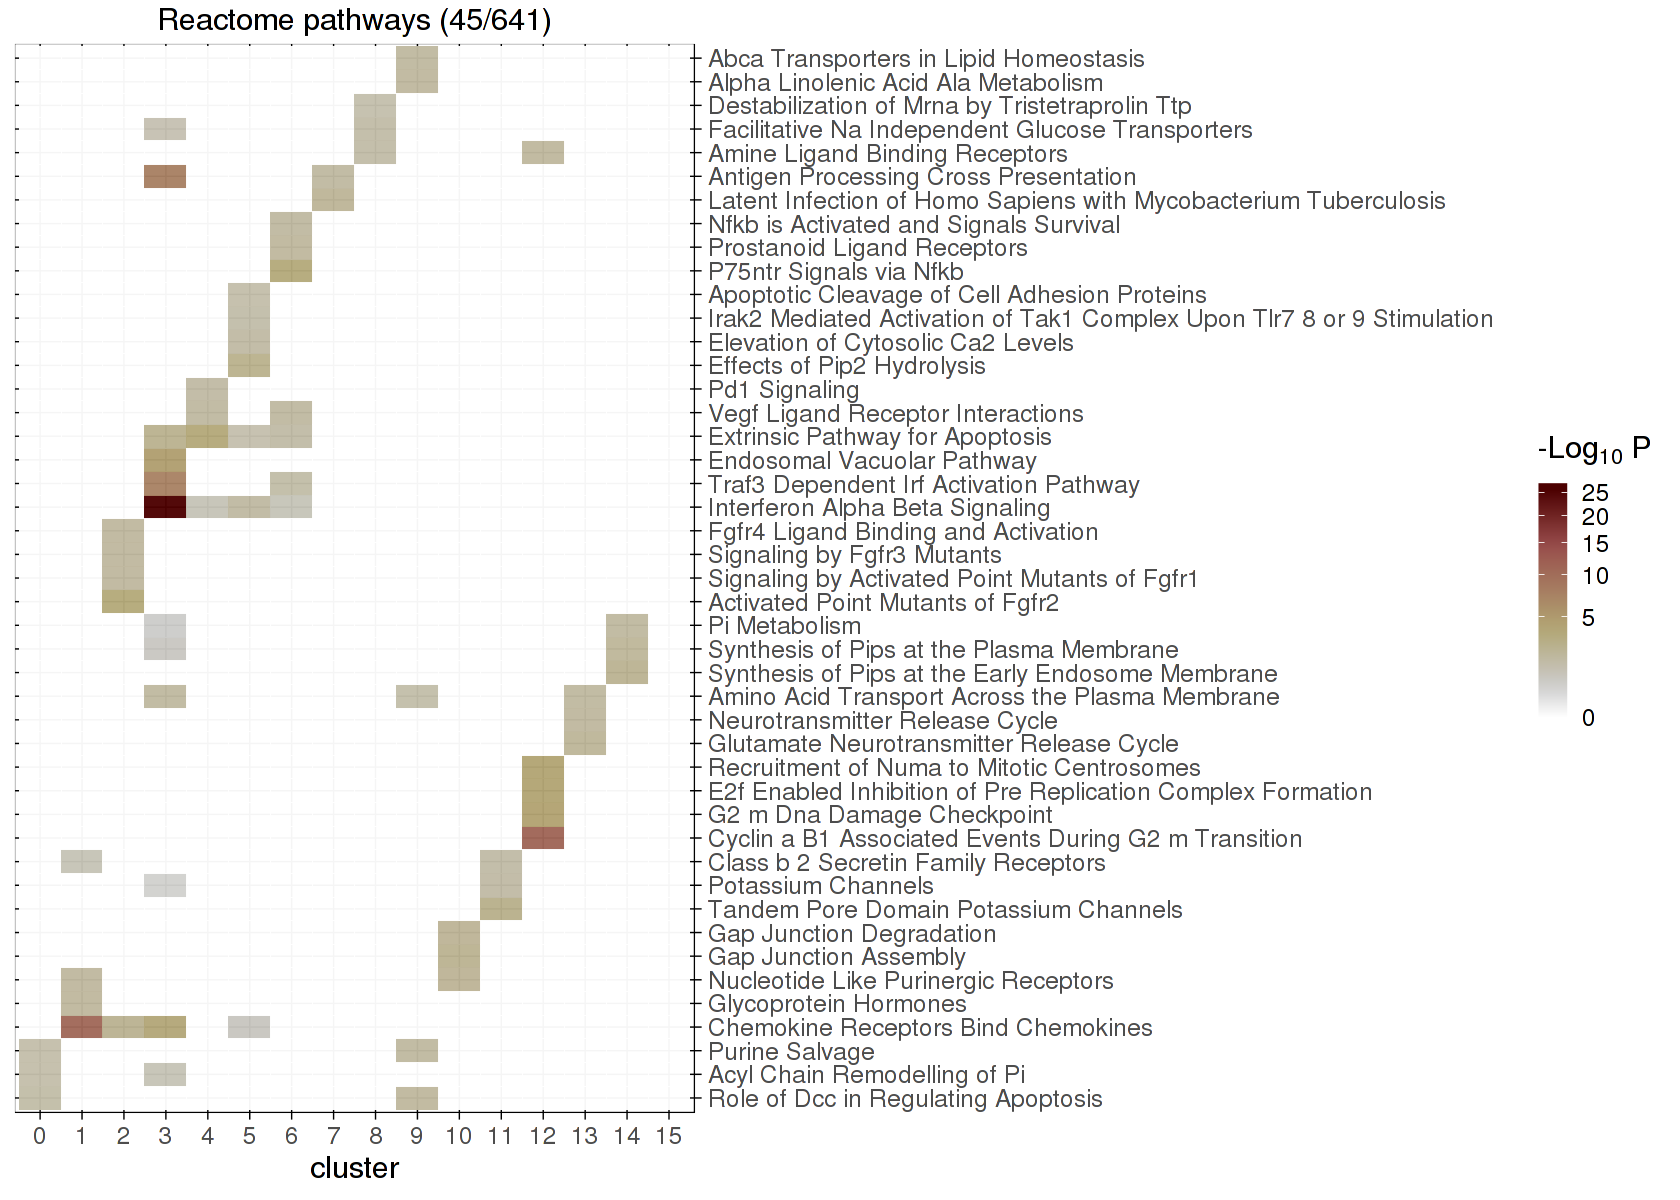

In [435]:
x <- fisher_hmark %>%
filter(x > 0) %>%
filter(stringr::str_detect(Name, "^REACTOME_")) %>%
# filter(!stringr::str_detect(Name, "^KEGG_")) %>%
# filter(!stringr::str_detect(Name, "^BIOCARTA_")) %>%
# filter(!stringr::str_detect(Name, "^REACTOME_")) %>%
# filter(!stringr::str_detect(Name, "^PID_")) %>%
# filter(pval < 0.05 / length(unique(Name))) %>% 
# filter(qval < 0.05) %>%
group_by(cluster) %>%
top_n(n = 3, wt = enrichment) %>%
arrange(cluster)

top_names <- unique(as.character(x$Name))

reactome_title <- sprintf(
  "Reactome pathways (%s/%s)",
  length(top_names),
  (fisher_hmark %>% filter(cluster == 0, str_detect(Name, "^REACTOME"))) %>% nrow
)
print(reactome_title)

better_name <- function(x) {
  tools::toTitleCase(tolower(str_replace_all(str_remove(x, "REACTOME_"), "_", " ")))
}

x <- fisher_hmark %>% filter(Name %in% top_names) %>%
mutate(Name = better_name(Name))

top_names <- better_name(top_names)

x$cluster <- factor(x$cluster, sort(unique(as.numeric(as.character(x$cluster)))))
x$Name <- factor(x$Name, top_names)

head(x)

options(repr.plot.width = 14, repr.plot.height = 10)

p_reactome <- ggplot(x) +
aes(
  x = cluster,
  y = Name,
#   fill = enrichment
  fill = -log10(pval)
) +
scale_y_discrete(position = "r", name = NULL) +
scico::scale_fill_scico(
  name = bquote("-Log"[10]~"P"),
  guide = guide_colorbar(barheight = 10),
  trans = "sqrt"
) +
geom_tile(alpha = 0.96) +
theme(panel.grid.major = element_line(color = "black", size = 0.3)) +
labs(title = reactome_title)

p_reactome

In [382]:
library(patchwork)

Writing file notebooks/figures/gene-categories-reactome.png
Writing file notebooks/figures/gene-categories-reactome.pdf


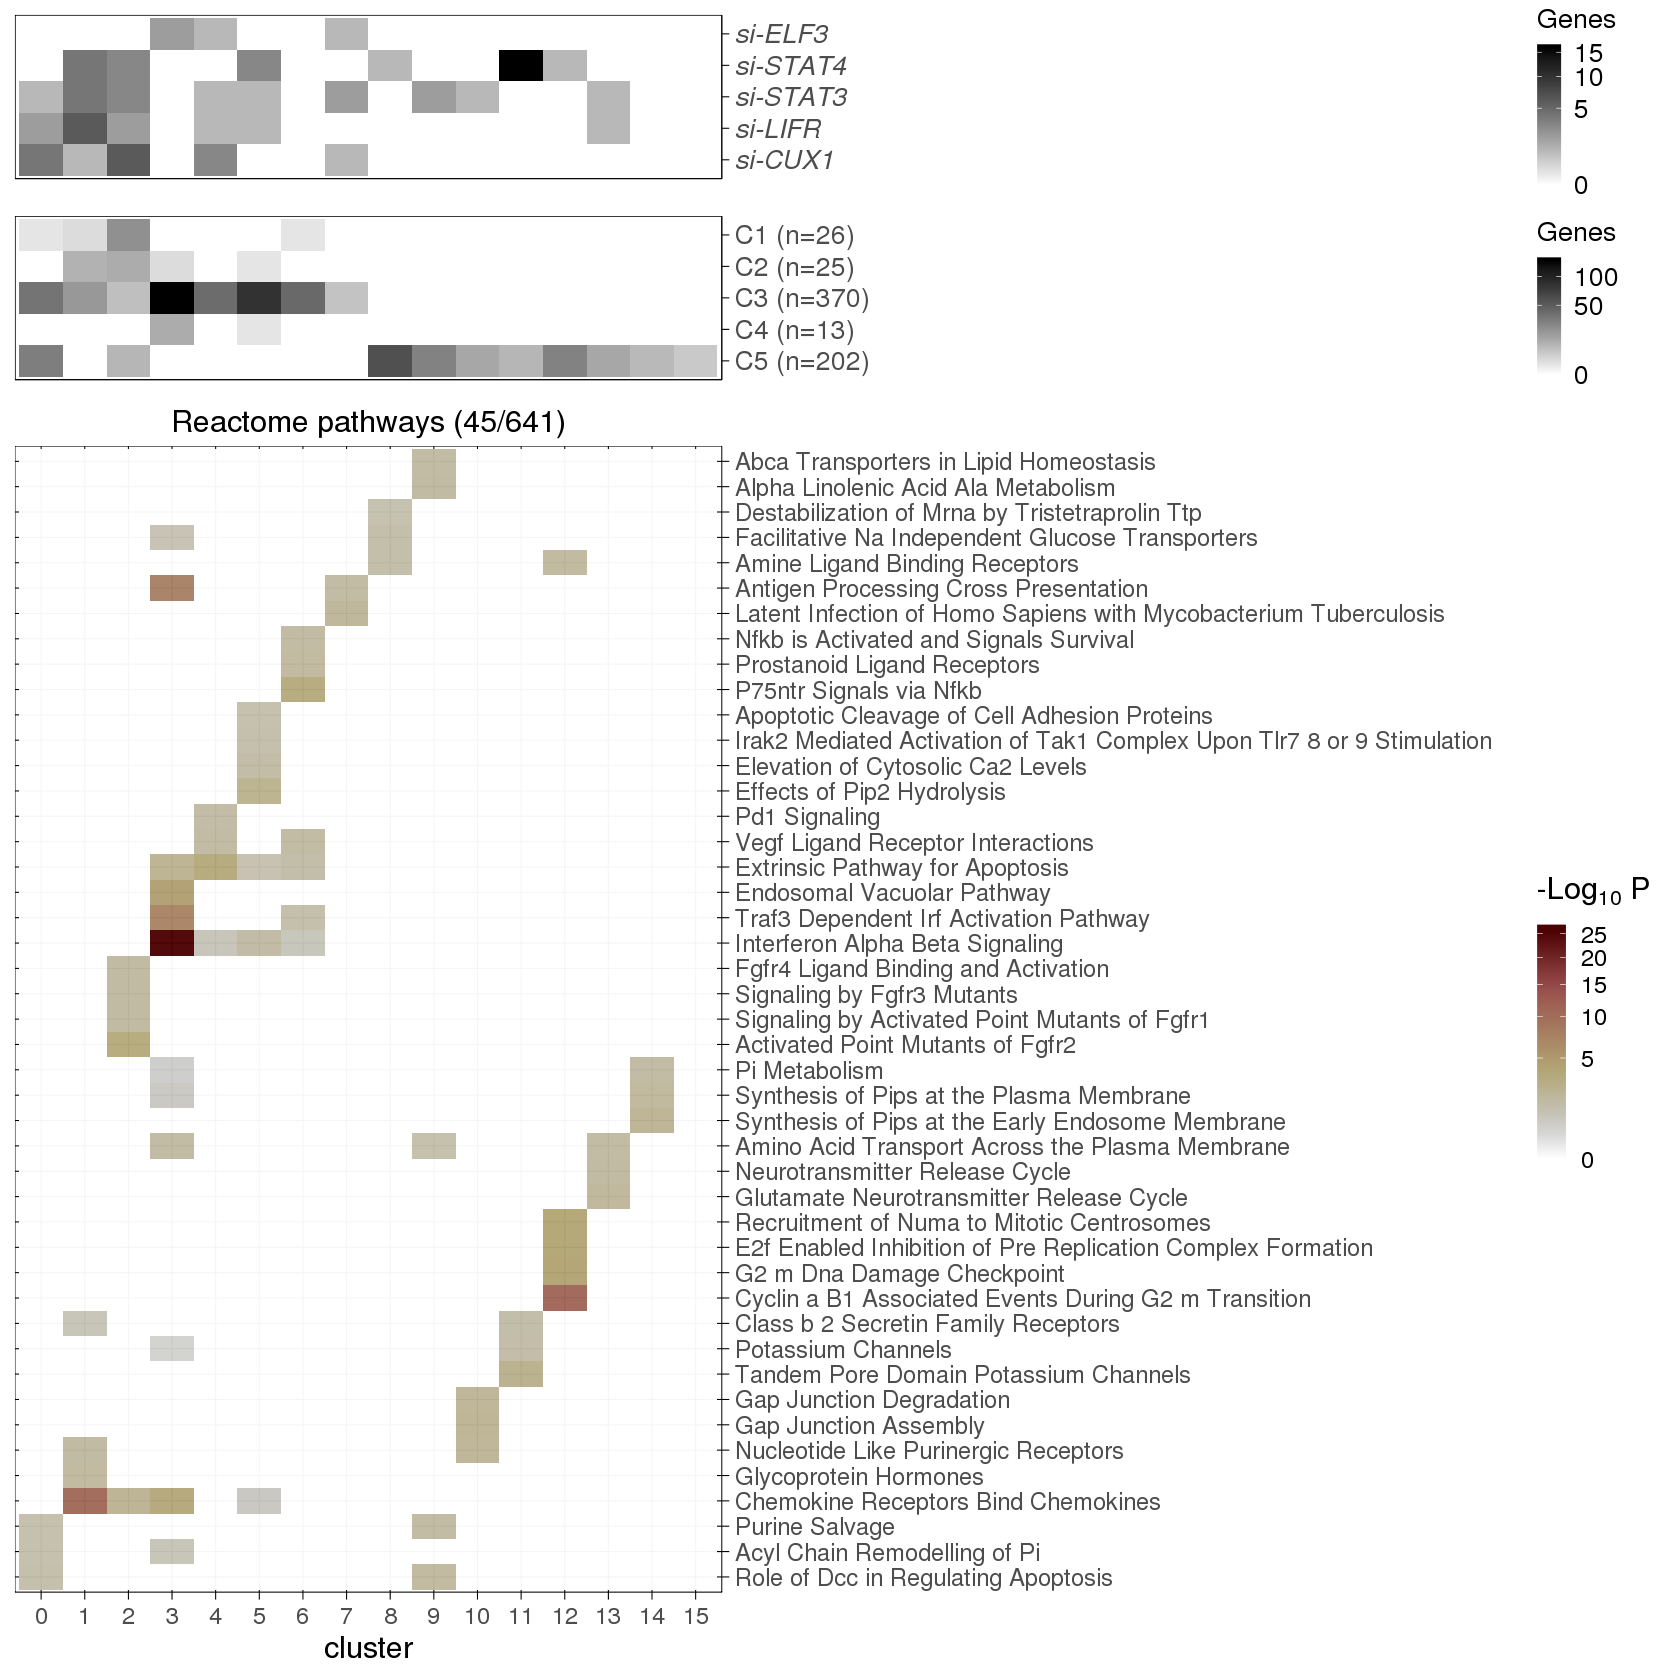

In [476]:
options(repr.plot.width = 14, repr.plot.height = 14)

show_plot(
  (p_sirna + theme(axis.text.x = element_blank(), axis.ticks.x = element_blank())) +
  (p_cat + theme(axis.text.x = element_blank(), axis.ticks.x = element_blank())) +
  p_reactome + plot_layout(ncol = 1, heights = c(1, 1, 7)),
  "gene-categories-reactome"
)

## KEGG

[1] "KEGG pathways (28/179)"


x,n,X,N,enrichment,orlow,orhigh,or,pval,Name,qval,cluster
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>
1,66,11,19879,27.381543,1.4028582,Inf,30.428503,0.03592958,Renin Angiotensin System,1,0
1,66,13,19879,23.168998,1.1865139,Inf,25.365862,0.04232424,Circadian Rhythm Mammal,1,0
1,66,60,19879,5.019949,0.2560781,Inf,5.150706,0.18113317,Nod Like Receptor Signaling Pathway,1,0
0,66,13,19879,1.000000,1.0000000,1,1.000000,1.00000000,Ascorbate and Aldarate Metabolism,1,0
0,66,14,19879,1.000000,1.0000000,1,1.000000,1.00000000,Primary Bile Acid Biosynthesis,1,0
0,66,15,19879,1.000000,1.0000000,1,1.000000,1.00000000,Phenylalanine Metabolism,1,0


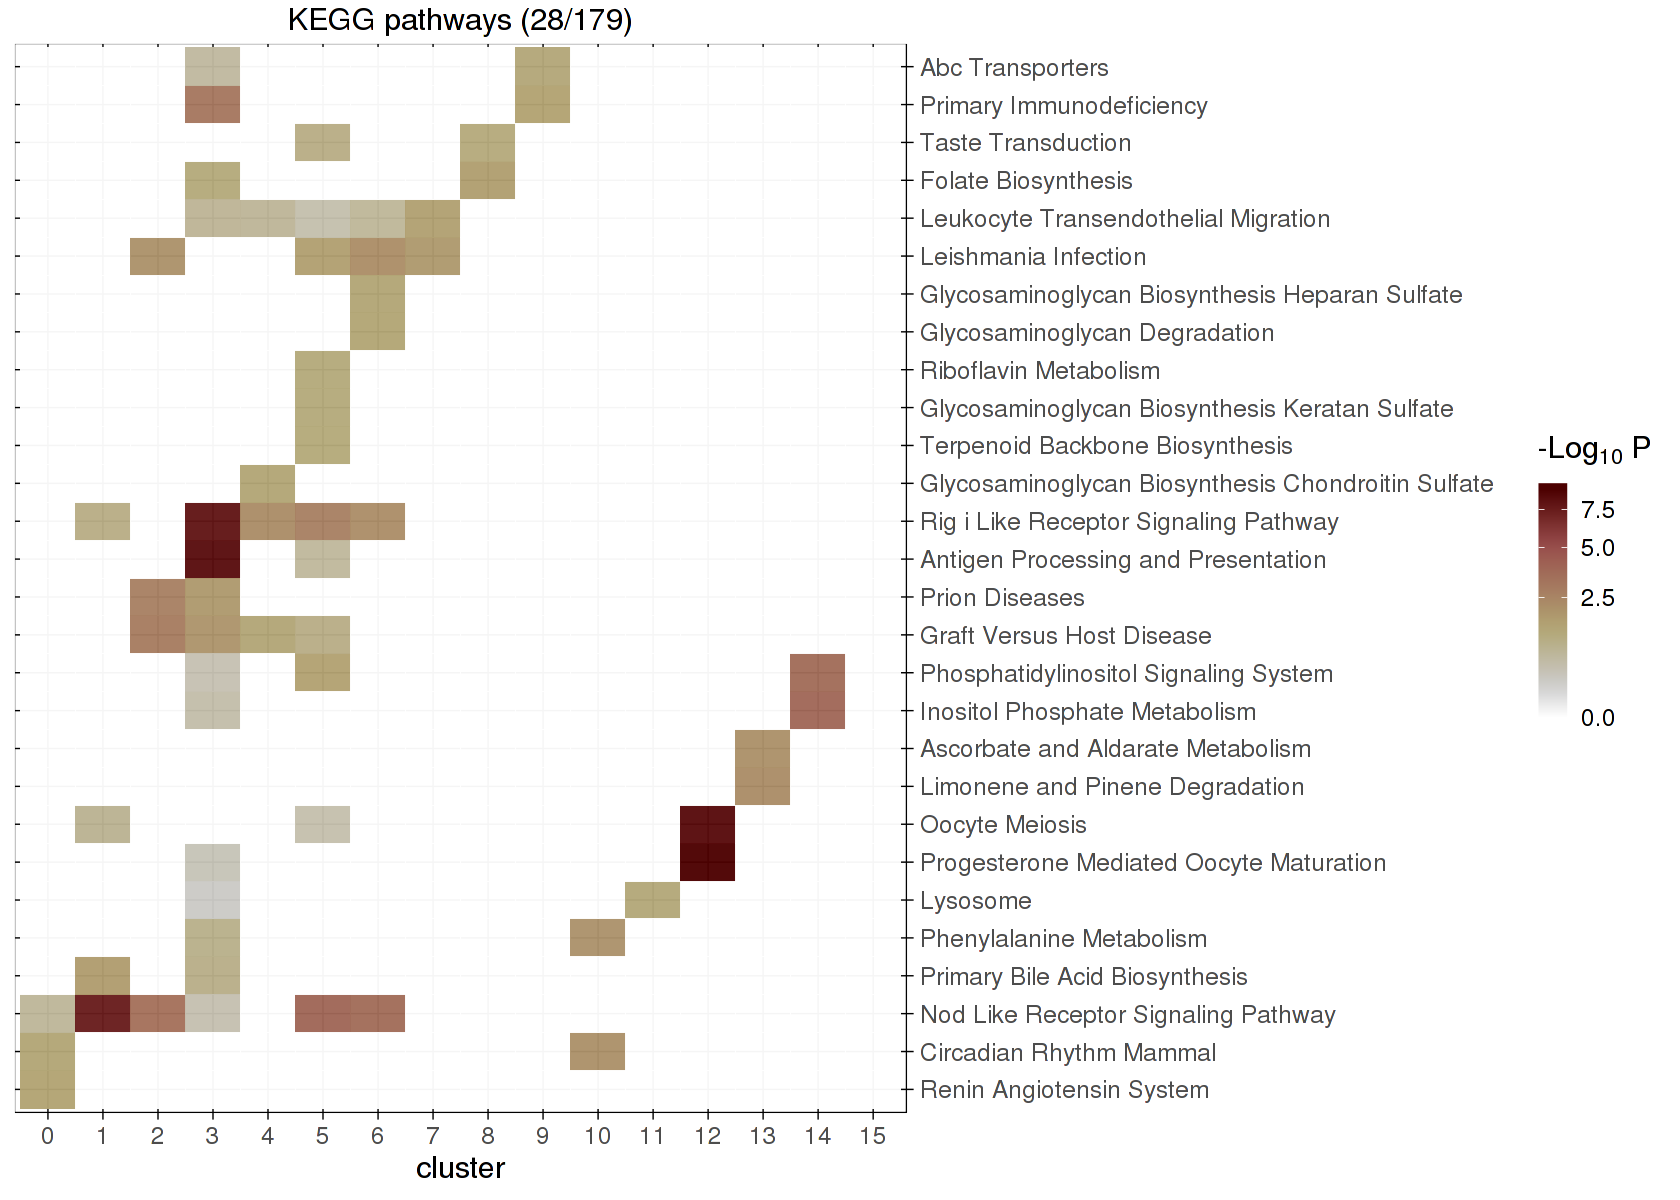

In [419]:
x <- fisher_hmark %>%
filter(x > 0) %>%
filter(stringr::str_detect(Name, "^KEGG_")) %>%
# filter(!stringr::str_detect(Name, "^KEGG_")) %>%
# filter(!stringr::str_detect(Name, "^BIOCARTA_")) %>%
# filter(!stringr::str_detect(Name, "^REACTOME_")) %>%
# filter(!stringr::str_detect(Name, "^PID_")) %>%
# filter(pval < 0.05 / length(unique(Name))) %>% 
# filter(qval < 0.05) %>%
group_by(cluster) %>%
top_n(n = 2, wt = enrichment) %>%
arrange(cluster)

top_names <- unique(as.character(x$Name))

kegg_title <- sprintf(
  "KEGG pathways (%s/%s)",
  length(top_names),
  (fisher_hmark %>% filter(cluster == 0, str_detect(Name, "^KEGG"))) %>% nrow
)
print(kegg_title)

better_name <- function(x) {
  tools::toTitleCase(tolower(str_replace_all(str_remove(x, "KEGG_"), "_", " ")))
}

x <- fisher_hmark %>% filter(Name %in% top_names) %>%
mutate(Name = better_name(Name))

top_names <- better_name(top_names)

x$cluster <- factor(x$cluster, sort(unique(as.numeric(as.character(x$cluster)))))
x$Name <- factor(x$Name, top_names)

head(x)

options(repr.plot.width = 14, repr.plot.height = 10)

p_kegg <- ggplot(x) +
aes(
  x = cluster,
  y = Name,
#   fill = enrichment
  fill = -log10(pval)
) +
scale_y_discrete(position = "r", name = NULL) +
scico::scale_fill_scico(
  name = bquote("-Log"[10]~"P"),
  guide = guide_colorbar(barheight = 10),
  trans = "sqrt"
) +
geom_tile(alpha = 0.96) +
theme(panel.grid.major = element_line(color = "black", size = 0.3)) +
labs(title = kegg_title)

p_kegg

## PID

[1] "Pathway Interaction Database (21/196)"


x,n,X,N,enrichment,orlow,orhigh,or,pval,Name,qval,cluster
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>
1,66,22,19879,13.690771,0.7002441,Inf,14.492124,0.07058708,NFKAPPAB CANONICAL,1,0
1,66,26,19879,11.584499,0.5922855,Inf,12.170488,0.08288314,P38 MKK3 6,1,0
1,66,33,19879,9.127181,0.4663936,Inf,9.505989,0.10401689,HIV NEF,1,0
1,66,61,19879,4.937655,0.2518656,Inf,5.064486,0.18386011,HIF1 TF,1,0
0,66,24,19879,1.000000,1.0000000,1,1.000000,1.00000000,HDAC CLASSIII,1,0
0,66,20,19879,1.000000,1.0000000,1,1.000000,1.00000000,IL27,1,0


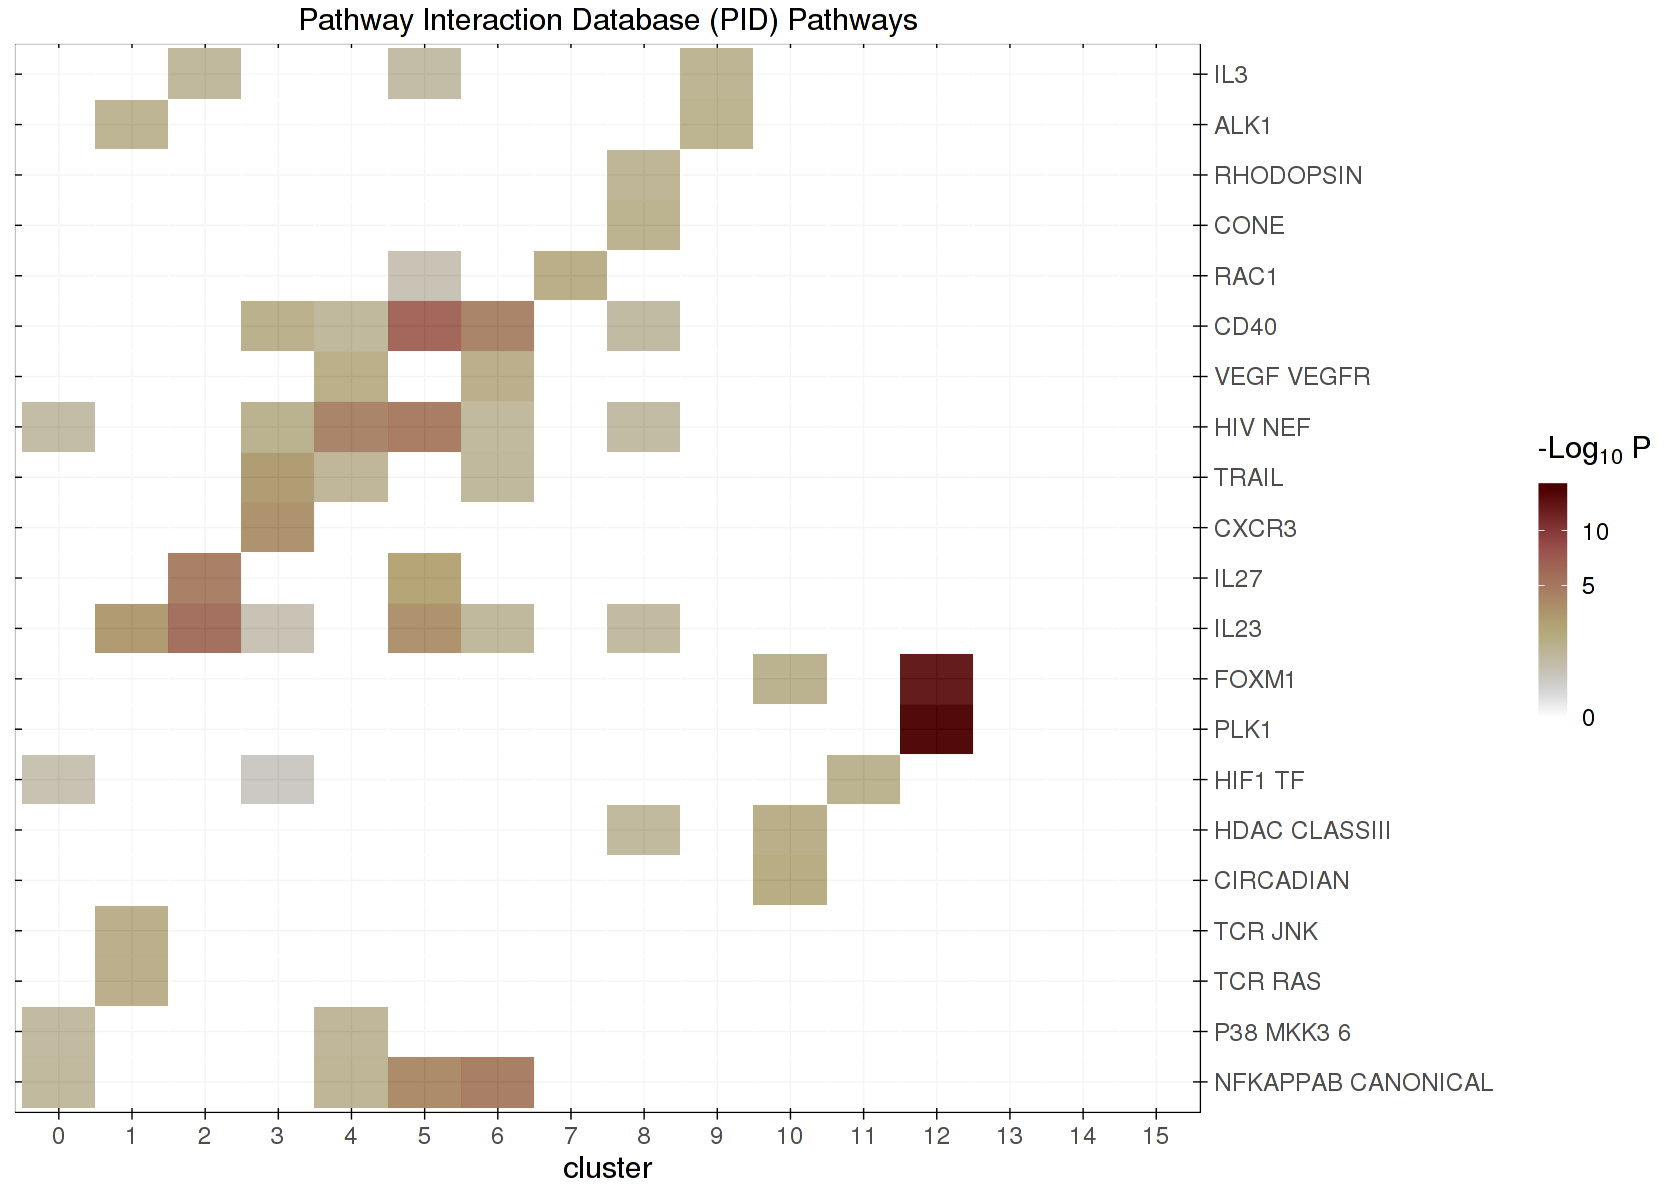

In [418]:
x <- fisher_hmark %>%
filter(x > 0) %>%
filter(stringr::str_detect(Name, "^PID_")) %>%
# filter(!stringr::str_detect(Name, "^KEGG_")) %>%
# filter(!stringr::str_detect(Name, "^BIOCARTA_")) %>%
# filter(!stringr::str_detect(Name, "^REACTOME_")) %>%
# filter(!stringr::str_detect(Name, "^PID_")) %>%
# filter(pval < 0.05 / length(unique(Name))) %>% 
# filter(qval < 0.05) %>%
group_by(cluster) %>%
top_n(n = 2, wt = enrichment) %>%
arrange(cluster)

top_names <- unique(as.character(x$Name))

pid_title <- sprintf(
  "Pathway Interaction Database (%s/%s)",
  length(top_names),
  (fisher_hmark %>% filter(cluster == 0, str_detect(Name, "^PID"))) %>% nrow
)
print(pid_title)

better_name <- function(x) {
#   x
  str_remove(str_replace_all(str_remove(x, "PID_"), "_", " "), " ?PATHWAY")
}

x <- fisher_hmark %>% filter(Name %in% top_names) %>%
mutate(Name = better_name(Name))

top_names <- better_name(top_names)

x$cluster <- factor(x$cluster, sort(unique(as.numeric(as.character(x$cluster)))))
x$Name <- factor(x$Name, top_names)

head(x)

options(repr.plot.width = 14, repr.plot.height = 10)

p_pid <- ggplot(x) +
aes(
  x = cluster,
  y = Name,
#   fill = enrichment
  fill = -log10(pval)
) +
scale_y_discrete(position = "r", name = NULL) +
scico::scale_fill_scico(
  name = bquote("-Log"[10]~"P"),
  guide = guide_colorbar(barheight = 10),
  trans = "sqrt"
) +
geom_tile(alpha = 0.96) +
theme(panel.grid.major = element_line(color = "black", size = 0.3)) +
labs(title = "Pathway Interaction Database (PID) Pathways")

p_pid

In [422]:
fisher_immuno_file <- "data/fisher_msigdb_c7_ensembl.rds"
if (!file.exists(fisher_immuno_file)) {
  fisher_immuno <- do.call(rbind, lapply(my_part_clusters, function(i) {
    res <- do_fisher(
      ids = my_ens[which(my_part$lab.hatK == i)],
      universe = rownames(log2tpm_batch),
      gene_sets = MSIGDB_C7_ENSEMBL
    )
    res$cluster <- i
    rownames(res) <- seq(nrow(res))
    res
  }))
  saveRDS(fisher_immuno, fisher_immuno_file)
} else {
  fisher_immmuno <- readRDS(fisher_immuno_file)
}

[1] "MSigDB C7 Immunological Pathways (31/4872)"


x,n,X,N,enrichment,orlow,orhigh,or,pval,Name,qval,cluster
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>
5,66,165,19879,9.127181,3.793009,Inf,10.063745,0.000220189,Gse13306 Lamina Propria vs Spleen Treg Dn,0.4969917,0
5,66,173,19879,8.705115,3.613358,Inf,9.582396,0.000274156,Gse36888 Stat5 Ab Knockin vs Wt Tcell Il2 Treated 6h Dn,0.4969917,0
3,66,162,19879,5.577722,1.549414,Inf,5.884734,0.016714681,Gse41978 Wt vs Id2 Ko and Bim Ko Klrg1 Low Effector Cd8 Tcell Up,0.8290472,0
3,66,168,19879,5.378517,1.493155,Inf,5.669087,0.018394896,Gse9988 Anti Trem1 vs Anti Trem1 and Lps Monocyte Dn,0.8290472,0
3,66,169,19879,5.346692,1.484171,Inf,5.634661,0.018683755,Gse9988 Lps vs Ctrl Treated Monocyte Up,0.8290472,0
3,66,177,19879,5.105033,1.415982,Inf,5.374226,0.021085627,Gse9988 Anti Trem1 vs Low Lps Monocyte Dn,0.8290472,0


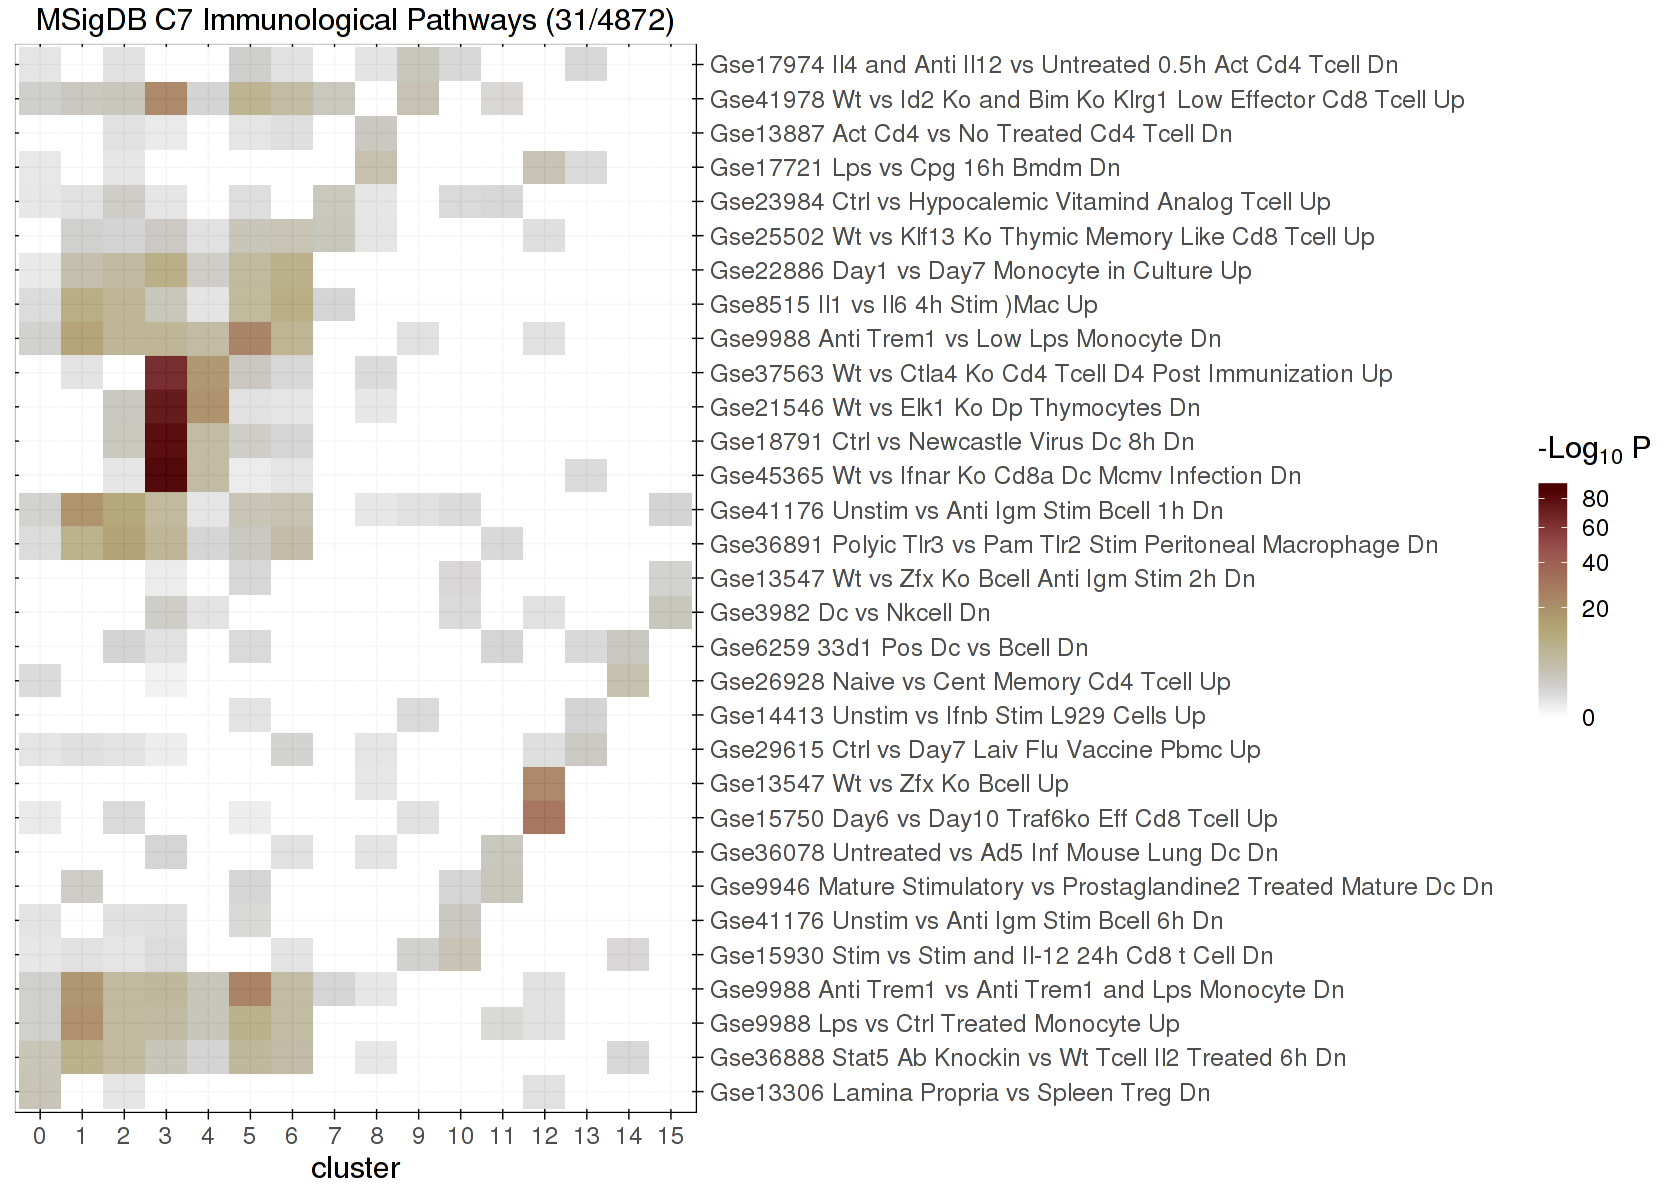

In [430]:
x <- fisher_immuno %>%
filter(x > 0) %>%
group_by(cluster) %>%
top_n(n = 2, wt = enrichment) %>%
arrange(cluster)

top_names <- unique(as.character(x$Name))

immuno_title <- sprintf(
  "MSigDB C7 Immunological Pathways (%s/%s)",
  length(top_names),
  (fisher_immuno %>% filter(cluster == 0)) %>% nrow
)
print(immuno_title)

better_name <- function(x) {
  tools::toTitleCase(tolower(str_replace_all(str_remove(x, "KEGG_"), "_", " ")))
}

x <- fisher_immuno %>% filter(Name %in% top_names) %>%
mutate(Name = better_name(Name))

top_names <- better_name(top_names)

x$cluster <- factor(x$cluster, sort(unique(as.numeric(as.character(x$cluster)))))
x$Name <- factor(x$Name, top_names)

head(x)

options(repr.plot.width = 14, repr.plot.height = 10)

p_immuno <- ggplot(x) +
aes(
  x = cluster,
  y = Name,
#   fill = enrichment
  fill = -log10(pval)
) +
scale_y_discrete(position = "r", name = NULL) +
scico::scale_fill_scico(
  name = bquote("-Log"[10]~"P"),
  guide = guide_colorbar(barheight = 10),
  trans = "sqrt"
) +
geom_tile(alpha = 0.96) +
theme(panel.grid.major = element_line(color = "black", size = 0.3)) +
labs(title = immuno_title)

p_immuno